# Gelman Schools and Hierarchical Pathology

##### Keywords: normal-normal model, hierarchical normal-normal model, hierarchical, divergences, non-centered hierarchical model, sampling distribution

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

From Gelman:

>a simple hierarchical model based on the normal distribu- tion, in which observed data are normally distributed with a different mean for each ‘group’ or ‘experiment,’ with known observation variance, and a normal population distribution for the group means. This model is sometimes termed the one-way normal random-effects model with known data variance and is widely applicable, being an important special case of the hierarchical normal linear model,...

## Statement of the model

The particular example we will deal with is called the 8-schools example, and is described thus:

>A study was performed for the Educational Testing Service to analyze the effects of special coaching programs on test scores. Separate randomized experiments were performed to estimate the effects of coaching programs for the SAT-V (Scholastic Aptitude Test- Verbal) in each of eight high schools. The outcome variable in each study was the score on a special administration of the SAT-V, a standardized multiple choice test administered by the Educational Testing Service and used to help colleges make admissions decisions; the scores can vary between 200 and 800, with mean about 500 and standard deviation about 100. The SAT examinations are designed to be resistant to short-term efforts directed specifically toward improving performance on the test; instead they are designed to reflect knowledge acquired and abilities developed over many years of education. Nevertheless, each of the eight schools in this study considered its short-term coaching program to be successful at increasing SAT scores. Also, there was no prior reason to believe that any of the eight programs was more effective than any other or that some were more similar in effect to each other than to any other.

>the estimated coaching effects are $\bar{y}_j$, and their sampling variances, $\sigma_j^2$... The estimates $\bar{y}_j$ are obtained by independent experiments and have approximately normal sampling distributions with sampling variances that are known, for all practical purposes, because the sample sizes in all of the eight experiments were relatively large, over thirty students in each school 

![](images/8schools.png)

Notice the bar on the y's and the mention of standard errors (rather than standard deviations) in the third column in the table above. Why is this?

The answer is that these are means taken over many (> 30) students in each of the schools. The general structure of this model can be written thus:

>Consider $J$ independent experiments, with experiment $j$ estimating the parameter $\theta_j$ from $n_j$ independent normally distributed data points, $y_{ij}$, each with known error variance $\sigma^2$; that is,

$$y_{ij} \vert \theta_j \sim N(\theta_j, \sigma^2), \, i = 1,...,n_j; j = 1,...,J.$$

We label the sample mean of each group $j$ as

$$\bar{y_j} = \frac{1}{n_j} \sum_{i=1}^{n_j} y_{ij}$$

with sampling variance:

$$\sigma_j^2 = \sigma^2/n_j$$

  
>We can then write the likelihood for each $\theta_j$ using the sufficient statistics, $\bar{y}_j$:

$$\bar{y_j} \vert \theta_j \sim N(\theta_j,\sigma_j^2).$$

This is

>a notation that will prove useful later because of the flexibility in allowing a separate variance $\sigma_j^2$ for the mean of each group $j$. ...all expressions will be implicitly conditional on the known values $\sigma_j^2$.... Although rarely strictly true, the assumption of known variances at the sampling level of the model is often an adequate approximation.

>The treatment of the model provided ... is also appropriate for situations in which the variances differ for reasons other than the number of data points in the experiment. In fact, the likelihood  can appear in much more general contexts than that stated here. For example, if the group sizes $n_j$ are large enough, then the means $\bar{y_j}$ are approximately normally distributed, given $\theta_j$, even when the data $y_{ij}$ are not. 

## Setting up the hierarchical model

We'll set up the modelled in what is called a "Centered" parametrization which tells us how $\theta_i$ is modelled: it is written to be directly dependent as a normal distribution from the hyper-parameters. 

In [2]:
J = 8
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])

We set up our priors in a Hierarchical model to use this centered parametrization. We can say: the $\theta_j$ is drawn from a Normal hyper-prior distribution with parameters $\mu$ and $\tau$. Once we get a $\theta_j$ then can draw the means from it given the data $\sigma_j$ and one such draw corresponds to our data.

$$
\mu \sim \mathcal{N}(0, 5)\\
\tau \sim \text{Half-Cauchy}(0, 5)\\
\theta_{j} \sim \mathcal{N}(\mu, \tau)\\
\bar{y_{j}} \sim \mathcal{N}(\theta_{j}, \sigma_{j})
$$

where $j \in \{1, \ldots, 8 \}$ and the
$\{ y_{j}, \sigma_{j} \}$ are given as data

In [3]:
with pm.Model() as schools1:

    mu = pm.Normal('mu', 0, sd=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta = pm.Normal('theta', mu=mu, sd=tau, shape=J)
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

In [4]:
with schools1:
    trace1 = pm.sample(5000, init=None, njobs=2, tune=500)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau_log__, mu]
100%|██████████| 5500/5500 [00:15<00:00, 365.39it/s]
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.690985903035, but should be close to 0.8. Try to increase the number of tuning steps.
There were 247 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.63919125529, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [5]:
pm.diagnostics.gelman_rubin(trace1), pm.diagnostics.effective_n(trace1)

({'mu': 1.000490513269084,
  'tau': 1.0120369801383995,
  'theta': array([ 1.00254569,  1.00092204,  0.99995591,  1.00055429,  0.99998707,
          1.0000066 ,  1.00360206,  1.00073661])},
 {'mu': 280.0,
  'tau': 238.0,
  'theta': array([ 444.,  479.,  661.,  526.,  875.,  691.,  340.,  514.])})

The Gelman-Rubin statistic seems fine, but notice how small the effective-n's are? Something is not quite right. Lets see traceplots.

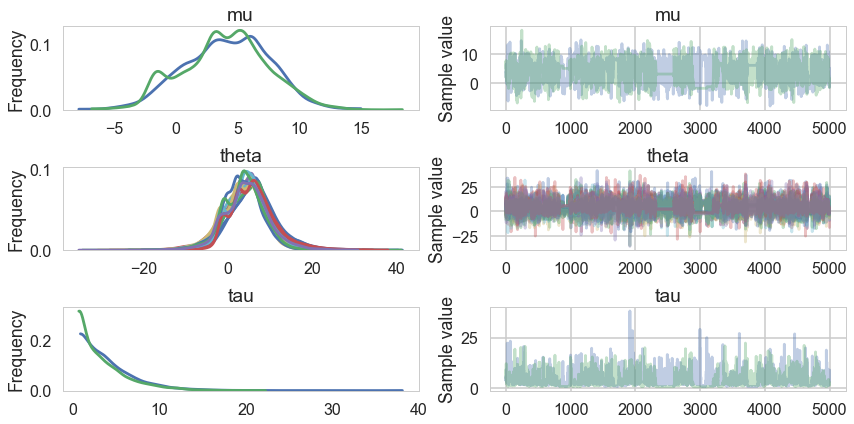

In [6]:
pm.traceplot(trace1);

Its hard to pick the thetas out but $\tau$ looks not so white-noisy. Lets zoom in:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116754400>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1166ba8d0>]], dtype=object)

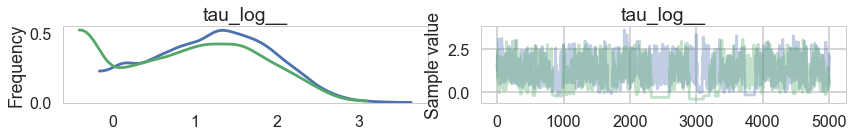

In [9]:
pm.traceplot(trace1, varnames=['tau_log__'])

There seems to be some stickiness at lower values in the trace. Zooming in even more helps us see this better:

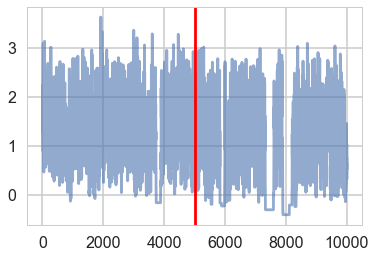

In [11]:
plt.plot(trace1['tau_log__'], alpha=0.6)
plt.axvline(5000, color="r")
#plt.plot(short_trace['tau_log_'][5000:], alpha=0.6);

We plot the cumulative mean of $log(\tau)$ as time goes on. This definitely shows some problems. Its biased above the value you would expect from many many samples.

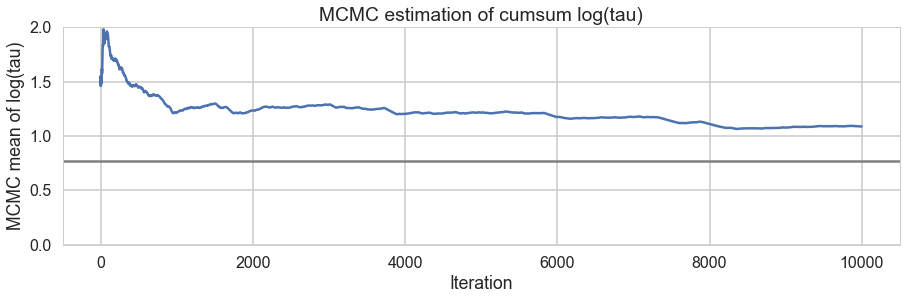

In [12]:
# plot the estimate for the mean of log(τ) cumulating mean
logtau = trace1['tau_log__']
mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of cumsum log(tau)')

## The problem with curvature

In-fact the "sticky's" in the traceplot are trying to drag the $\tau$ trace down to the true value, eventually. If we wait for the heat-death of the universe long this will happen, given MCMC's guarantees. But clearly we want to get there with a finite number of samples.

We can diagnose whats going on by looking for divergent traces in pymc3. In newer versions, these are obtained by a special boolean component of the trace.

In [13]:
divergent = trace1['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size/len(trace1)
print('Percentage of Divergent %.5f' % divperc)

Number of Divergent 357
Percentage of Divergent 0.07140


What does divergent mean? These are situations in which our symplectic integrator has gone Kaput, as illustrated in this diagram below from Betancourt's review:

![](images/sympldiv.png)

When a MCMC sampler (this problem is worse in non HMC models) encounters a region of high curvature it gets stuck, and goes off elsewhere, after a while. In the HMC scenario, the symplectic integrator diverges. What happens is that in encounters a region of high curvature which our timestep size $\epsilon$ is not able to resolve. Things become numerically unstable and the integrator veers off towards infinite energies, clearly not conserving energy any more.

![](images/sympldiv2.png)

Where is this curvature coming from? Things become a bit easier to understand if we plot the joint distribution of one of the thetas against a hyper-parameter. And we see that there is a triangular funnel structure with the hyperparameter spanning orders of magnitude in value. Using pymc we can plot where the divergences occur, and while they can occur anywhere they seem to be clustered in the neck of the distribution.

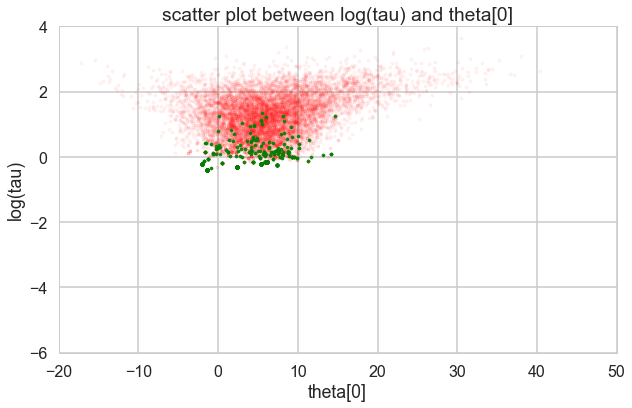

In [22]:
theta_trace = trace1['theta']
theta0 = theta_trace[:, 0]
plt.figure(figsize=(10, 6))
plt.scatter(theta0[divergent == 0], logtau[divergent == 0], color='r', s=10, alpha=0.05)
plt.scatter(theta0[divergent == 1], logtau[divergent == 1], color='g', s=10, alpha=0.9)
plt.axis([-20, 50, -6, 4])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[0]')
plt.show()

Two things have now happened...we have an increasing inability to integrate in the neck of this funnel, and we have lost confidence that our sampler is now actually characterizing this funnel well.

`pymc3` warning system also captures this, and the information can be drawn from there as well

In [39]:
trace1.report.ok

False

In [45]:
trace1.report._chain_warnings[0][0]

SamplerWarning(kind=<WarningType.DIVERGENCE: 1>, message='Energy change in leapfrog step is too large: 1624.79235214.', level='debug', step=353, exec_info=None, extra={'theta': array([ 5.45180751,  4.95166739,  3.82850001,  4.22962979,  4.36062314,
        6.36974169,  4.72219313,  5.18415398]), 'tau_log__': array(-0.10357888919470949), 'mu': array(5.486739282359358)})

## Funnels in hierarchical models

As is discussed in Betancourt and Girolami (2015) from where the following diagrams are taken, a funnel structure is common in Hierarchical models, and reflects strong correlations between down-tree parameters such as thetas, and uptree parameters such as $\phi = \mu, \tau$ here.

![](images/girolam1.png)

The funnel between $v = log(\tau)$ and $\theta_i$ in the hierarchical Normal-Normal model looks like this:

![](images/girolam2.png)

The problem is that a sampler must sample both the light and dark regions as both have enough probability mass.

### Divergences are good things

This is because they can help us diagnose problems in our samplers. Chances are that in a region with divergences the sampler is having problems exploring.

There is a second reason besides curvature and symplectic integration which affects the efficiency of HMC. This is the range of transitions a HMC sampler can make. For a euclidean mass-matrix sampler, the transitions are of the order of the range in kinetic energy, which itself is chi-squared distributed (since p is Gaussian and a sum of gaussians is a chi-squared). Thus, in expectation, the variation in $K$ is of oder $d/2$ where $d$ is the dimension of the target. Since hierarchical structures correlate variables between levels, they also induce large changes in energy density, which our transitions dont explore well.

## Non-centered Model

So what is to be done? We could change the kinetic energy using methods such as Riemannian Monte-Carlo HMC, but thats beyond our scope. But, just as in the case with the regression example earlier, a re-parametrization comes to our rescue. We want to reduce the levels in the hierarchy, as shown here:

![](images/girolam3.png)

We change our model to:

$$
\mu \sim \mathcal{N}(0, 5)\\
\tau \sim \text{Half-Cauchy}(0, 5)\\
\nu_{j} \sim \mathcal{N}(0, 1)\\
\theta_{j} = \mu + \tau\nu_j \\
\bar{y_{j}} \sim \mathcal{N}(\theta_{j}, \sigma_{j})
$$

Notice how we have factored the dependency of $\theta$ on $\phi = \mu, \tau$ into a deterministic
transformation between the layers, leaving the
actively sampled variables uncorrelated. 

This does two things for us: it reduces steepness and curvature, making for better stepping. It also reduces the strong change in densities, and makes sampling from the transition distribution easier.

In [23]:
with pm.Model() as schools2:
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=5)
    nu = pm.Normal('nu', mu=0, sd=1, shape=J)
    theta = pm.Deterministic('theta', mu + tau * nu)
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

In [24]:
with schools2:
    trace2 = pm.sample(5000, init=None, njobs=2, tune=500)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau_log__, mu]
100%|██████████| 5500/5500 [00:12<00:00, 445.95it/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


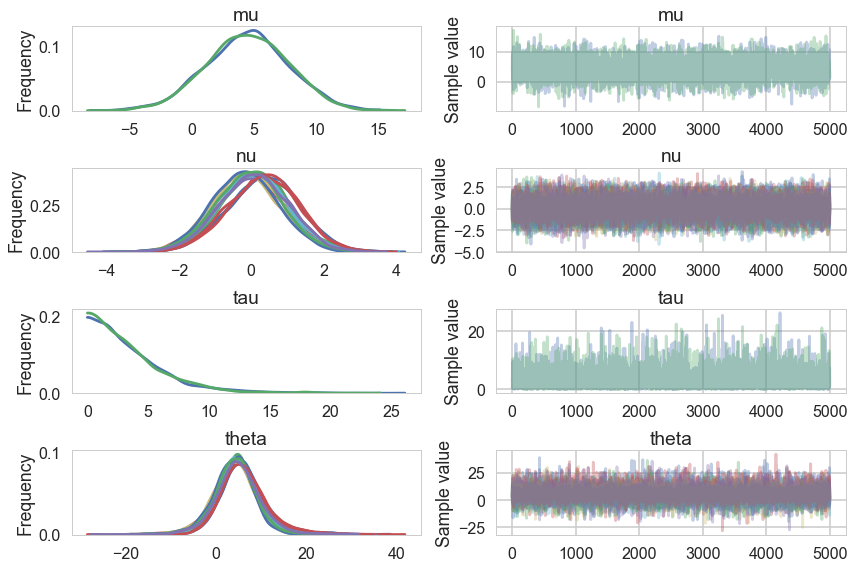

In [48]:
pm.traceplot(trace2);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116c14048>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x116c367b8>]], dtype=object)

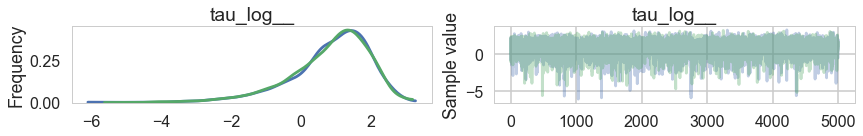

In [25]:
pm.traceplot(trace2, varnames=['tau_log__'])

Ok, so this seems to look better!

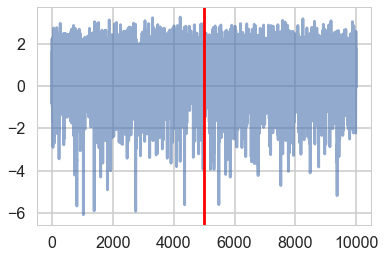

In [26]:
plt.plot(trace2['tau_log__'], alpha=0.6)
plt.axvline(5000, color="r")

And the effective number of iterations hs improved as well:

In [27]:
pm.diagnostics.gelman_rubin(trace2), pm.diagnostics.effective_n(trace2)

({'mu': 1.0000108935357401,
  'nu': array([ 0.99991086,  1.00007561,  0.99996423,  0.99991367,  1.00001948,
          0.99993215,  0.99990613,  1.00015964]),
  'tau': 0.99997109046913057,
  'theta': array([ 0.99991096,  0.99996292,  0.99990009,  0.99990008,  0.99992957,
          0.9999427 ,  0.99992104,  0.99992762])},
 {'mu': 10000.0,
  'nu': array([ 10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.,
          10000.]),
  'tau': 6549.0,
  'theta': array([  8752.,  10000.,  10000.,  10000.,  10000.,  10000.,   9709.,
           9566.])})

And we reach the true value better as the number of samples increases, decreasing our bias

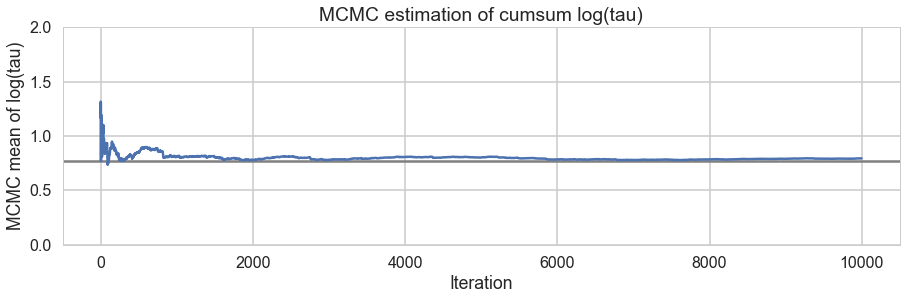

In [28]:
# plot the estimate for the mean of log(τ) cumulating mean
logtau = trace2['tau_log__']
mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of cumsum log(tau)')

How about our divergences? They have decreased too.

In [29]:
divergent = trace2['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size/len(trace2)
print('Percentage of Divergent %.5f' % divperc)

Number of Divergent 14
Percentage of Divergent 0.00280


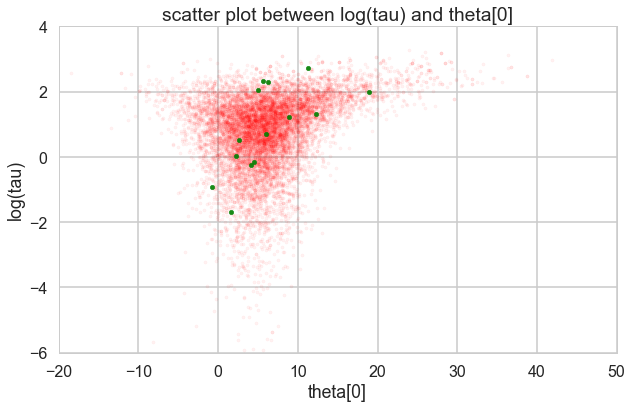

In [32]:
theta_trace = trace2['theta']
theta0 = theta_trace[:, 0]
plt.figure(figsize=(10, 6))
plt.scatter(theta0[divergent == 0], logtau[divergent == 0], color='r', s=10, alpha=0.05)
plt.scatter(theta0[divergent == 1], logtau[divergent == 1], color='g', s=20, alpha=0.9)
plt.axis([-20, 50, -6, 4])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[0]')
plt.show()

Look how much longer the funnel actually is. And we have explored this much better.

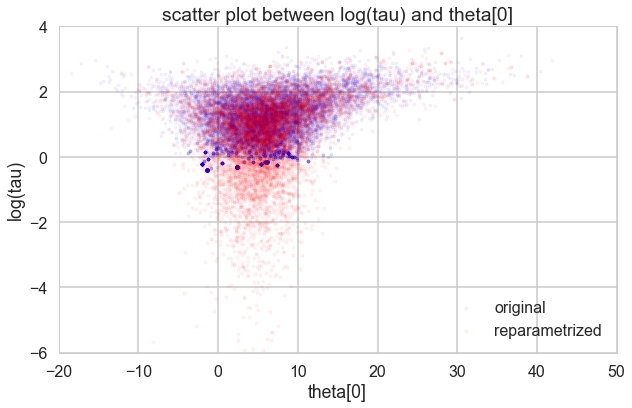

In [35]:
theta01 = trace1['theta'][:, 0]
logtau1 = trace1['tau_log__']

theta02 = trace2['theta'][:, 0]
logtau2 = trace2['tau_log__']


plt.figure(figsize=(10, 6))
plt.scatter(theta01, logtau1, alpha=.05, color="b", label="original", s=10)
plt.scatter(theta02, logtau2, alpha=.05, color="r", label='reparametrized', s=10)
plt.axis([-20, 50, -6, 4])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[0]')
plt.legend()


It may not be possible in all models to achieve this sort of decoupling. In that case, Riemannian HMC, where we generalize the mass matrix to depend upon position, explicitly tackling high-curvature, can help.